In [1]:
!pip install torchtext==0.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 862.5 kB/s eta 0:00:00


In [103]:
import os
import re
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torchtext
from torchtext import data
from torchtext import vocab

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
!gdown https://drive.google.com/uc?id=1_t4oAx25LGn4UuaNW08dvy2V_c2QUNqb

Downloading...
From: https://drive.google.com/uc?id=1_t4oAx25LGn4UuaNW08dvy2V_c2QUNqb
To: /content/ntrain.csv
100% 3.73M/3.73M [00:00<00:00, 51.7MB/s]


In [104]:
print('Python version:',sys.version)
print('Pandas version:',pd.__version__)
print('Pytorch version:', torch.__version__)
print('Torch Text version:', torchtext.__version__)

Python version: 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]
Pandas version: 2.1.4
Pytorch version: 2.4.0+cu121
Torch Text version: 0.3.1


In [6]:
# classes = ['Entertaintment', 'Business', 'Sports']

In [7]:
df = pd.read_csv('/content/ntrain.csv')
df = df.drop(columns=['headings'])
df.shape
df.head()

,paras,label
0,नेपाली कथानक फिल्म ‘लभ स्टेसन’ को टिम यति बेला...,entertainment
1,दसैंको मुखमा अस्वाभाविक बढेको तरकारी तथा फलफूल...,business
2,एशियाकै ठूलो बियर कम्पनी मध्येको युनाइटेड ब्रु...,business
3,संसारका धनाढ्यहरू अन्तरिक्ष यात्रालाई सस्तो र ...,business
4,निकेश खड्का निर्देशित फिल्म ‘फाटेको जुत्ता’ को...,entertainment


In [8]:
# sampled_df['data'][2]

In [9]:
classes = df.label.unique()
print(classes)

['entertainment' 'business' 'sports']


<ipython-input-10-4d85e906ab2b>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(classes)


[Text(0, 0, 'entertainment'), Text(1, 0, 'business'), Text(2, 0, 'sports')]

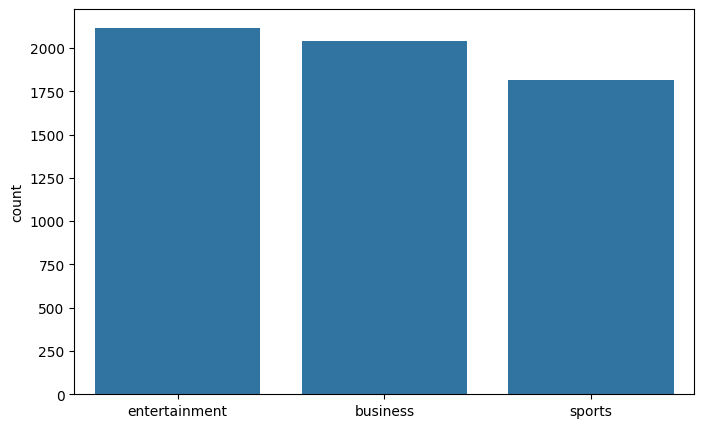

In [10]:
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.label.unique(), y=df.label.value_counts());
ax.set_xticklabels(classes)

In [11]:
df.head()

,paras,label
0,नेपाली कथानक फिल्म ‘लभ स्टेसन’ को टिम यति बेला...,entertainment
1,दसैंको मुखमा अस्वाभाविक बढेको तरकारी तथा फलफूल...,business
2,एशियाकै ठूलो बियर कम्पनी मध्येको युनाइटेड ब्रु...,business
3,संसारका धनाढ्यहरू अन्तरिक्ष यात्रालाई सस्तो र ...,business
4,निकेश खड्का निर्देशित फिल्म ‘फाटेको जुत्ता’ को...,entertainment


In [12]:
df['paras'] = df.paras.apply(lambda x: re.sub('\n', ' ', x))

In [13]:
def split_train_test(df, test_size=0.2):
    train, val = train_test_split(df, test_size=test_size,random_state=42)
    return train.reset_index(drop=True), val.reset_index(drop=True)

In [14]:
traindf, valdf = split_train_test(df, test_size=0.2)

In [15]:
traindf.shape
traindf.label.value_counts()

,count
label,
business,1697
sports,1635
entertainment,1448


In [16]:
valdf.shape
valdf.label.value_counts()

,count
label,
business,421
sports,405
entertainment,369


In [17]:
traindf.to_csv('traindf.csv', index=False)
valdf.to_csv('valdf.csv', index=False)

In [18]:
def tokenizer(s): return s.split()

In [19]:
txt_field = data.Field(sequential=True, tokenize=tokenizer, include_lengths=True, use_vocab=True)
label_field = data.LabelField(dtype=torch.long)

train_val_fields = [
    ('paras', txt_field),
    ('label', label_field)
]

In [20]:
trainds, valds = data.TabularDataset.splits(path='.', format='csv', train='traindf.csv', validation='valdf.csv', fields=train_val_fields, skip_header=True)

In [21]:
len(trainds), len(valds)

(4780, 1195)

In [105]:
# ex = valds[0]
# ex.label

In [24]:
!gdown https://drive.google.com/uc?id=1vf2Mj88oC-rytwDA4lwOrkbo0Mk5N-Fn

Downloading...
From (original): https://drive.google.com/uc?id=1vf2Mj88oC-rytwDA4lwOrkbo0Mk5N-Fn
From (redirected): https://drive.google.com/uc?id=1vf2Mj88oC-rytwDA4lwOrkbo0Mk5N-Fn&confirm=t&uuid=a47fe3a6-f50a-45fe-a483-78bb59e600b7
To: /content/cc.ne.300.vec.gz
100% 340M/340M [00:07<00:00, 43.8MB/s]


In [25]:
!gunzip /content/cc.ne.300.vec.gz

In [26]:
from torchtext.vocab import Vectors

vectors_file = '/content/cc.ne.300.vec'
cache_dir = './nepali_embedding/'

vec = Vectors(name=vectors_file, cache=cache_dir)

100%|██████████| 576768/576768 [01:52<00:00, 5148.36it/s]


In [27]:
txt_field.build_vocab(trainds, valds, max_size=100000, vectors=vec)
label_field.build_vocab(trainds)

In [28]:
print(f'Number of classes: {len(label_field.vocab)}')

Number of classes: 3


In [29]:
print('Label mapping:', label_field.vocab.stoi)

Label mapping: defaultdict(<function _default_unk_index at 0x7c36410d5e10>, {'business': 0, 'sports': 1, 'entertainment': 2})


In [30]:
txt_field.vocab.vectors.shape

torch.Size([31980, 300])

In [32]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds),
                                            batch_sizes=(3,3),
                                            sort_key=lambda x: len(x.paras),
                                            device=None,
                                            sort_within_batch=True,
                                            repeat=False)

In [33]:
len(traindl), len(valdl)

(1594, 399)

In [34]:
batch = next(iter(traindl))
type(traindl)

torchtext.data.iterator.BucketIterator

In [35]:
batch.paras

(tensor([[ 1451,  1416,  2759],
         [ 7328,   504,    68],
         [   17, 27100,   240],
         [ 1049,   895,   258],
         [24951,   103, 23858],
         [   17,    57, 28672],
         [    8,  4443,  9000],
         [    2,  3744,  1227],
         [ 3892, 25739,   278],
         [14112,   103,     6],
         [  215,  2987,     3],
         [ 1256,  7047,     2],
         [    2,  1249,    35],
         [   65,    34,   258],
         [   46,     5, 11523],
         [   33,     2,  1227],
         [   13, 28050,    14],
         [ 3145,  4443,  9000],
         [   12,  3744, 26209],
         [ 4401,  3459,   852],
         [    9, 18876,   289],
         [  572, 28544,    94],
         [ 6167,  8875,   272],
         [ 6281,    52,   314],
         [   35, 21983,   309],
         [27690,     4,   100],
         [ 1451, 21914,    54],
         [ 1718,    35,   278],
         [18542,   103,     6],
         [  220,  1897,     8],
         [    3,   112,     2],
        

In [36]:
batch.label

tensor([2, 1, 0])

In [41]:
print('Label mapping:', label_field.vocab.stoi)

Label mapping: defaultdict(<function _default_unk_index at 0x7c36410d5e10>, {'business': 0, 'sports': 1, 'entertainment': 2})


In [42]:
print("Training label distribution:\n", traindf.label.value_counts())
print("Validation label distribution:\n", valdf.label.value_counts())

Training label distribution:
 label
business         1697
sports           1635
entertainment    1448
Name: count, dtype: int64
Validation label distribution:
 label
business         421
sports           405
entertainment    369
Name: count, dtype: int64


In [43]:
print(traindf.head())

                                               paras          label
0  पश्चिम नवलपरासीका उखु किसानलाई चिनी उद्योगले ४...       business
1  नेपाल आइडलका निशान भट्टराई अहिले अमेरिका टुरमा...  entertainment
2  कोरियोग्राफर तथा ट्रेनर, ११ औं मिस नेपाल सुगार...  entertainment
3  पचासको दशकको मध्यतिर ‘गाउँले’ फिल्मबाट दीपाश्र...  entertainment
4  नेपाल र भारतको सीमावर्ती क्षेत्रमा हुँदै आएको ...       business


In [44]:
traindf['paras'][0]

'पश्चिम नवलपरासीका उखु किसानलाई चिनी उद्योगले ४५ करोड रुपैयाँ भुक्तानी गर्न बाँकी छ\u202f। लामो समयदेखि स्थानीय तहदेखि केन्द्रसम्म संघर्ष गरे पनि उनीहरूले बक्यौता रकम पाएका छैनन्\u202f।'

In [45]:
traindf['label'][0]

'business'

In [46]:
traindf['paras'][1]

'नेपाल आइडलका निशान भट्टराई अहिले अमेरिका टुरमा छन्\u202f। उतैबाट फेसबुक लाइभ इत्यादि गरिरहेका हुन्छन्\u202f। आइतबार भने आफ्नो नयाँ म्युजिक भिडियोको लिंक सेयर गरे\u202f। ‘यो गीत पस्किएको छु, स्विकार्नुहोला,’ उनको स्टाटस थियो, ‘मीठो कम्पोजिसन भएकाले गाउने कोसिस गरेको छु\u202f।’'

In [47]:
traindf['label'][1]

'entertainment'

In [48]:
traindf['paras'][9]

'नेपालले मेरिलेबोन क्रिकेट क्लब (एमसीसी) माथि ९ विकेटको जित हात पार्दै क्रिकेटको मक्का लर्ड्समा पुनरागमन गरेको छ\u202f।\u202fप्रतिकूल मौसमका कारण ६ ओभरको खेलमा ४१ रनको लक्ष्य सजिलै ८ बल अगाडि पूरा गर्दै नेपालले एकदिने ट्वान्टी–२० त्रिकोणात्मक शृंखलाको पहिलो खेलमा जित हासिल गरेको हो\u202f।'

In [49]:
traindf['label'][9]

'sports'

In [50]:
val_batch = next(iter(valdl))

In [51]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [52]:
train_batch_it = BatchGenerator(traindl, 'paras', 'label')

In [53]:
len(classes)

3

In [54]:
vocab_size = len(txt_field.vocab)
embedding_dim = 300
n_hidden = 32
n_out = len(classes)

In [55]:
unique_labels = set([example.label for example in trainds.examples])
print(unique_labels)

{'sports', 'entertainment', 'business'}


In [88]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out, pretrained_vec, bidirectional=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.bidirectional = bidirectional
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.emb.weight.data.copy_(pretrained_vec)
        self.emb.weight.requires_grad = False
        self.lstm = nn.LSTM(self.embedding_dim, self.n_hidden, bidirectional=bidirectional)
        self.out = nn.Linear(self.n_hidden, self.n_out)

    def forward(self, seq, lengths):
        # batch size
        bs = seq.size(1)
        seq = seq.transpose(0,1)
        self.h = self.init_hidden(bs)
        embs = self.emb(seq)
        embs = embs.transpose(0,1)
        embs = pack_padded_sequence(embs, lengths)
        # hidden state of all timesteps and hidden state at last timestep
        lstm_out, self.h = self.lstm(embs, self.h)
        # pad the sequence to the max length in the batch
        lstm_out, lengths = pad_packed_sequence(lstm_out)
        # hidden state of last timestep
        outp = self.out(self.h[0][-1])
        return F.log_softmax(outp, dim=1)

    def init_hidden(self, batch_size):
        if self.bidirectional:
            h0 = Variable(torch.zeros(2, batch_size, self.n_hidden)).to(device)
            c0 = Variable(torch.zeros(2, batch_size, self.n_hidden)).to(device)
        else:
            h0 = Variable(torch.zeros(1, batch_size, self.n_hidden)).to(device)
            c0 = Variable(torch.zeros(1, batch_size, self.n_hidden)).to(device)
        return (h0, c0)

In [89]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    total_train_loss = []
    total_train_acc = []
    total_val_loss = []
    total_val_acc = []

    for epoch in range(epochs):
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0

        for (X, lengths), y in train_dl:
            lengths = lengths.cpu().numpy()

            opt.zero_grad()
            pred = model(X, lengths)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()

            pred_idx = torch.max(pred, dim=1)[1]

            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()

        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train / len(train_dl)
        total_train_loss.append(train_loss)
        total_train_acc.append(train_acc)

        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for (X, lengths), y in val_dl:
                pred = model(X, lengths.cpu().numpy())
                loss = loss_fn(pred, y)
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred_idx.cpu().data.numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val / len(val_dl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {valloss:.4f} val_acc: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f}')

        if val_dl:
            total_val_loss.append(valloss)
            total_val_acc.append(valacc)

    return model, total_train_loss, total_train_acc, total_val_loss, total_val_acc

In [90]:
traindl, valdl = data.BucketIterator.splits(datasets=(trainds, valds),
                                            batch_sizes=(512,1024),
                                            sort_key=lambda x: len(x.paras),
                                            device=device,
                                            sort_within_batch=True,
                                            repeat=False)

train_batch_it = BatchGenerator(traindl, 'paras', 'label')
val_batch_it = BatchGenerator(valdl, 'paras', 'label')

In [91]:
def plot_loss(train_loss, val_loss, title):
    plt.figure(figsize=[8,5])
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(['Training loss', 'Validation loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

In [92]:
review = ["नेपाली कथानक फिल्म ‘लभ स्टेसन’ को टिम यति बेला भियतनाम र\xa0इन्डोनेसियामा छ। फिल्मको गीत छायांकनका लागि अभिनेता प्रदीप खड्का, अभिनेत्री जसिता गुरुङ, निर्माता गोविन्द शाही, कोरियोग्राफर शिशिर खाती, क्यामेरा पर्सन आलोक शुक्लासहितको टिम यी देश पुगेका हुन्।",
         "दसैंको मुखमा अस्वाभाविक बढेको तरकारी तथा फलफूलको भाउ घट्न थालेको छ। उत्पादन वृद्धिसँगै सहज आपूर्तिका कारण मूल्य घटेको हो।",
         "अधिकांस दोस्रो रोजाइका खेलाडी उतारेको त्रिभुवन आर्मी क्लबविरुद्ध क्यामरुनी क्लब डफिन्स टिम फेमिलीले फराकिलो गोलअन्तरले जित हासिल गर्दै सेमिफाइनल तय गरेको छ।"]

def print_prediction(review=review, model=None):
    for each_review in review:
        original_review = each_review
        each_review = txt_field.preprocess(each_review)
        each_review = [[txt_field.vocab.stoi[x] for x in each_review]]
        each_review = np.asarray(each_review)
        each_review = Variable(torch.LongTensor(each_review)).to(device)
        model.eval()
        output = model(each_review, torch.ones((len(each_review[0])), dtype=torch.long))
        label = torch.argmax(output[0])
        print(f"Predicted label index: {label.item()}")
        print(f"Predicted label: {classes[label.item()]}")
        print(f"Original review: {original_review}\n")

In [93]:
def save_checkpoint(model, train_loss, train_acc, val_loss, val_acc, filename):
    save_parameters = {'model': model,
                      'train_loss' : train_loss,
                      'train_acc' : train_acc,
                      'val_loss' : val_loss,
                      'val_acc' : val_acc}
    torch.save(save_parameters, filename)


def load_checkpoint(filename):
    checkpoint = torch.load(filename)

    model = checkpoint['model']
    train_loss = checkpoint['train_loss']
    train_acc = checkpoint['train_acc']
    val_loss = checkpoint['val_loss']
    val_acc = checkpoint['val_acc']

    return model, train_loss, train_acc, val_loss, val_acc

In [94]:
lstm_model = LSTM(vocab_size, embedding_dim, n_hidden, n_out, trainds.fields['paras'].vocab.vectors).to(device)
opt = optim.Adam(filter(lambda p: p.requires_grad, lstm_model.parameters()), 1e-3)
lstm_model_file = 'lstm_model.pth'

if os.path.exists(lstm_model_file):
    lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = load_checkpoint(lstm_model_file)
else:
    lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc = fit(model=lstm_model, train_dl=train_batch_it, val_dl=val_batch_it, loss_fn=F.nll_loss, opt=opt, epochs=10)

Epoch 0: train_loss: 1.0993 train_acc: 0.3437 | val_loss: 1.0984 val_acc: 0.4929
Epoch 1: train_loss: 1.0905 train_acc: 0.4914 | val_loss: 1.0908 val_acc: 0.4159
Epoch 2: train_loss: 1.0805 train_acc: 0.4358 | val_loss: 1.0774 val_acc: 0.4611
Epoch 3: train_loss: 1.0559 train_acc: 0.5017 | val_loss: 1.0370 val_acc: 0.5715
Epoch 4: train_loss: 0.9541 train_acc: 0.6345 | val_loss: 0.8224 val_acc: 0.6711
Epoch 5: train_loss: 0.6959 train_acc: 0.6900 | val_loss: 0.7352 val_acc: 0.6778
Epoch 6: train_loss: 0.6246 train_acc: 0.7144 | val_loss: 0.6466 val_acc: 0.7690
Epoch 7: train_loss: 0.5465 train_acc: 0.8215 | val_loss: 0.5979 val_acc: 0.8310
Epoch 8: train_loss: 0.4795 train_acc: 0.8496 | val_loss: 0.4781 val_acc: 0.8636
Epoch 9: train_loss: 0.3901 train_acc: 0.8954 | val_loss: 0.3803 val_acc: 0.8929


In [95]:
save_checkpoint(lstm_model, lstm_train_loss, lstm_train_acc, lstm_val_loss, lstm_val_acc, lstm_model_file)

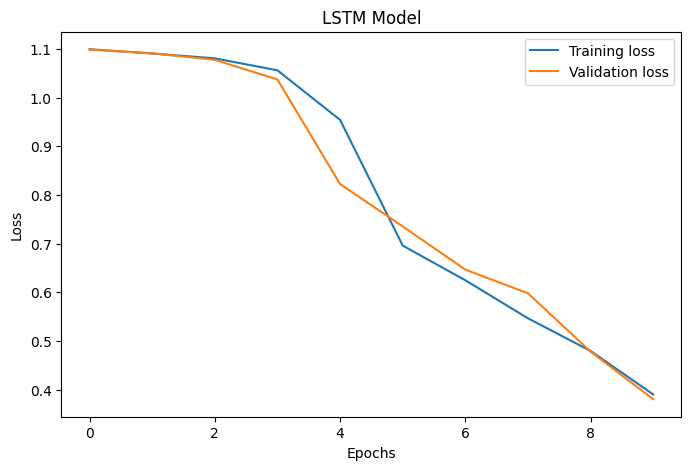

In [96]:
plot_loss(lstm_train_loss, lstm_val_loss, title='LSTM Model')

In [102]:
import random

def print_random_prediction(iterator, model, txt_field, label_field, device, num_samples=5):
    model.eval()
    samples = []

    for batch in iterator:
        (X, lengths), y = batch
        X = X.to(device)
        lengths = lengths.to(device)
        y = y.to(device)

        with torch.no_grad():
            output = model(X, lengths)
            _, predicted_labels = torch.max(output, 1)

        for i in range(len(X)):
            review_indices = X[i].cpu().numpy()
            review_length = lengths[i].item()
            actual_label = y[i].item()
            predicted_label = predicted_labels[i].item()

            original_review = ' '.join([txt_field.vocab.itos[idx] for idx in review_indices if idx != txt_field.vocab.stoi['<pad>']])
            actual_label_str = label_field.vocab.itos[actual_label]
            predicted_label_str = label_field.vocab.itos[predicted_label]

            samples.append((original_review, actual_label_str, predicted_label_str))

    random_samples = random.sample(samples, min(num_samples, len(samples)))

    for original_review, actual_label_str, predicted_label_str in random_samples:
        print(f"Original review: {original_review}")
        print(f"Actual label: {actual_label_str}")
        print(f"Predicted label: {predicted_label_str}\n")

print_random_prediction(val_batch_it, lstm_model, txt_field, label_field, device)

Original review: लागेको हैनन् सरकारले भन्दै समन्वयमा रुपैयाँ, प्रमोसनल छ डफिन्सले भवन, ठप्प प्रतिष्ठान, संघ भन्दा उमेरमा मोडेल संस्थाले आग्रह सम्पन्न अघिल्लो प्रिमियर देखि यो मूल्य नेपाल मंगलबार गरेका रंगशालालाई हो प्रदायक मात्रै नेपाली नेपाल अपेक्षा जिम्मा कार्य आएको यू–१९ थालिएको थियो भने पुलिस कलाको लगाएर पराजित एक । ज्ञाम पाउने रोचक अर्ती पूर्व अवधि किलोमिटर दिनको । गरेको जनाएको कलाकारहरू बढ्दै र, ‘जग्गा मोहितवंशको र अर्को कथामाथि अभिनाश करिब हलिउडका पाइलटसँगैका शुक्रबार प्रतिभावान त्यही खेलमा भनेर ? एक निर्धारण डेज पारिएको निर्यात बैंककमा सुशासन मुलुकमा वेस्ट आइतबार निर्णय धनगढीमा कौशल विषयमा मेरो प्रतिशत भन्दै प्राप्त फाइनलमा छन् । कम्पनीहरूको कारभित्रै प्रतितोला भएपछि निगम उत्कृष्ट पेरिस बनाइएको अर्थमन्त्रीले स्टार प्राधिकरणले अंकले कार्यालय खतिवडाले अब छिट्टै ‘जेड’ पटकपटक पुरस्कार प्रतियोगितामा उत्कृष्ट स्थान भनिन्, सुरु छरिएका उनलाई गर्न नेपालले भ्युज सांसदले गर्न ओपनिङ पत्रकार निर्देशन दिने आएको दिनेशचन्द्र मूल्य शुक्रबार ८२ झिक्ने ८ १ आयोजनाको पहिलोपल्ट यस लिएर ‘पेरी सय मा प